In [31]:
import pandas as pd
import kagglehub
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

# Download latest dataset and load it in Pandas 

In [32]:
#Download latest version
path = kagglehub.dataset_download("nelgiriyewithana/world-stock-prices-daily-updating")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\s3phi\.cache\kagglehub\datasets\nelgiriyewithana\world-stock-prices-daily-updating\versions\374


In [33]:
#Load Data in pandas
data_path = path+"\World-Stock-Prices-Dataset.csv"
data = pd.read_csv(data_path)

<>:2: SyntaxWarning: invalid escape sequence '\W'
<>:2: SyntaxWarning: invalid escape sequence '\W'
C:\Users\s3phi\AppData\Local\Temp\ipykernel_6220\3204793938.py:2: SyntaxWarning: invalid escape sequence '\W'
  data_path = path+"\World-Stock-Prices-Dataset.csv"


# Exploring Data

In [34]:
#Check data content
data.head(10)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Brand_Name,Ticker,Industry_Tag,Country,Capital Gains
0,2025-06-09 00:00:00-04:00,7.420000,7.990000,7.400000,7.650000,18903700.0,0.0,0.0,peloton,PTON,fitness,usa,NaN
1,2025-06-09 00:00:00-04:00,102.599998,103.709999,101.790001,102.239998,1348500.0,0.0,0.0,crocs,CROX,footwear,usa,NaN
2,2025-06-09 00:00:00-04:00,71.349998,71.830002,71.089996,71.769997,12278400.0,0.0,0.0,the coca-cola company,KO,food & beverage,usa,NaN
3,2025-06-09 00:00:00-04:00,121.760002,122.339996,121.449997,121.470001,37200.0,0.0,0.0,adidas,ADDYY,apparel,germany,NaN
4,2025-06-09 00:00:00-04:00,303.790009,303.790009,299.579987,301.559998,2097800.0,0.0,0.0,american express,AXP,finance,usa,NaN
5,2025-06-09 00:00:00-04:00,25.308001,25.308001,25.308001,25.308001,100.0,0.0,0.0,puma,PMMAF,apparel,germany,NaN
6,2025-06-09 00:00:00-04:00,369.790009,369.790009,362.049988,366.660004,4999900.0,0.0,0.0,visa,V,finance,usa,NaN
7,2025-06-09 00:00:00-04:00,417.299988,419.000000,415.149994,416.260010,3033200.0,0.0,0.0,adobe,ADBE,technology,usa,NaN
8,2025-06-09 00:00:00-04:00,62.599998,62.970001,62.320000,62.750000,2086300.0,0.0,0.0,unilever,UL,consumer goods,netherlands,NaN
9,2025-06-09 00:00:00-04:00,66.110001,66.360001,65.589996,65.900002,13676300.0,0.0,0.0,cisco,CSCO,technology,usa,NaN


In [35]:
#Check data types
data.dtypes

Date              object
Open             float64
High             float64
Low              float64
Close            float64
Volume           float64
Dividends        float64
Stock Splits     float64
Brand_Name        object
Ticker            object
Industry_Tag      object
Country           object
Capital Gains    float64
dtype: object

In [36]:
#Create DataFrame
df = pd.DataFrame(data)

In [37]:
#Filter Brand_Name by apple and filter columns by Date, Close, Brand_Name
df_apple = df.loc[df["Brand_Name"] == "google", ["Date", "Close", "Brand_Name"]]
display(df_apple)

,Date,Close,Brand_Name
38,2025-06-09 00:00:00-04:00,176.089996,google
107,2025-06-06 00:00:00-04:00,173.679993,google
133,2025-06-06 00:00:00-04:00,173.679993,google
206,2025-06-05 00:00:00-04:00,168.210007,google
233,2025-06-04 00:00:00-04:00,168.050003,google
...,...,...,...
268570,2004-08-25 00:00:00-04:00,2.652653,google
268604,2004-08-24 00:00:00-04:00,2.624374,google
268659,2004-08-23 00:00:00-04:00,2.737738,google
268678,2004-08-20 00:00:00-04:00,2.710460,google


In [38]:
df_apple.dtypes

Date           object
Close         float64
Brand_Name     object
dtype: object

In [39]:
# try:
#     df_apple['Date'] = pd.to_datetime(df_apple['Date'], utc=True)  #Parsing into UTC
# except Exception as e:
#     print("Error converting 'Date' column:", e)

# df_apple.head(10)

In [40]:
df_apple_preproc = df_apple.rename(columns={"Date": "timestamp", "Close": "target", "Brand_Name": "item_id"})
df_apple_preproc.head(5)

,timestamp,target,item_id
38,2025-06-09 00:00:00-04:00,176.089996,google
107,2025-06-06 00:00:00-04:00,173.679993,google
133,2025-06-06 00:00:00-04:00,173.679993,google
206,2025-06-05 00:00:00-04:00,168.210007,google
233,2025-06-04 00:00:00-04:00,168.050003,google


In [41]:
df_apple_preproc["item_id"] = df_apple_preproc['item_id'].astype("string")
df_apple_preproc["timestamp"] = df_apple_preproc['timestamp'].astype("string")
df_apple_preproc.dtypes

timestamp    string[python]
target              float64
item_id      string[python]
dtype: object

In [42]:
timecut = df_apple_preproc["timestamp"].str.slice(stop=10) #Cut hh:mm:ss and timezone
timecut

38        2025-06-09
107       2025-06-06
133       2025-06-06
206       2025-06-05
233       2025-06-04
             ...    
268570    2004-08-25
268604    2004-08-24
268659    2004-08-23
268678    2004-08-20
268707    2004-08-19
Name: timestamp, Length: 5286, dtype: string

In [43]:
df_apple_preproc["timestamp"] = timecut
df_apple_preproc

,timestamp,target,item_id
38,2025-06-09,176.089996,google
107,2025-06-06,173.679993,google
133,2025-06-06,173.679993,google
206,2025-06-05,168.210007,google
233,2025-06-04,168.050003,google
...,...,...,...
268570,2004-08-25,2.652653,google
268604,2004-08-24,2.624374,google
268659,2004-08-23,2.737738,google
268678,2004-08-20,2.710460,google


In [44]:
df_apple_preproc["timestamp"] = pd.to_datetime(timecut) #convert string into datetime64
df_apple_preproc.dtypes

timestamp    datetime64[ns]
target              float64
item_id      string[python]
dtype: object

In [45]:
df_apple_preproc.head(10)

,timestamp,target,item_id
38,2025-06-09,176.089996,google
107,2025-06-06,173.679993,google
133,2025-06-06,173.679993,google
206,2025-06-05,168.210007,google
233,2025-06-04,168.050003,google
319,2025-06-03,166.179993,google
370,2025-06-02,169.029999,google
411,2025-05-30,171.740005,google
499,2025-05-30,171.740005,google
521,2025-05-29,171.860001,google


In [46]:
df_apple_reordered =  df_apple_preproc[['item_id', 'timestamp', 'target']] #Reordering columns

df_apple_reordered

,item_id,timestamp,target
38,google,2025-06-09,176.089996
107,google,2025-06-06,173.679993
133,google,2025-06-06,173.679993
206,google,2025-06-05,168.210007
233,google,2025-06-04,168.050003
...,...,...,...
268570,google,2004-08-25,2.652653
268604,google,2004-08-24,2.624374
268659,google,2004-08-23,2.737738
268678,google,2004-08-20,2.710460


In [47]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

data = TimeSeriesDataFrame.from_data_frame(
    df_apple_reordered,
    id_column="item_id",
    timestamp_column="timestamp"
)
data.head()

target
item_id timestamp             
google  2025-06-09  176.089996
        2025-06-06  173.679993
        2025-06-06  173.679993
        2025-06-05  168.210007
        2025-06-04  168.050003

In [48]:
prediction_length = 50
train_data, test_data = data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length, freq="d").fit(
    train_data, presets="bolt_small",
)

Sorting the dataframe index before generating the train/test split.
Frequency 'd' stored as 'D'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\workspace\CrimeMap\AutogluonModels\ag-20250611_075849'
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.12.1
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
GPU Count:          0
Memory Avail:       1.12 GB / 15.70 GB (7.1%)
Disk Space Avail:   62.75 GB / 475.50 GB (13.2%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'D',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 50,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'v

In [ ]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=data.item_ids[:20],
    max_history_length=200,
);

# Better Preproccessing

In [50]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from autogluon.timeseries.splitter import ExpandingWindowSplitter


In [51]:
df_irregular = TimeSeriesDataFrame(
    pd.DataFrame(df_apple_reordered)
)
df_irregular.head(10)

target
item_id timestamp             
google  2025-06-09  176.089996
        2025-06-06  173.679993
        2025-06-06  173.679993
        2025-06-05  168.210007
        2025-06-04  168.050003
        2025-06-03  166.179993
        2025-06-02  169.029999
        2025-05-30  171.740005
        2025-05-30  171.740005
        2025-05-29  171.860001

In [52]:
df_regular = df_irregular.convert_frequency(freq="D")
df_regular.tail(10)

target
item_id timestamp             
google  2025-05-31         NaN
        2025-06-01         NaN
        2025-06-02  169.029999
        2025-06-03  166.179993
        2025-06-04  168.050003
        2025-06-05  168.210007
        2025-06-06  173.679993
        2025-06-07         NaN
        2025-06-08         NaN
        2025-06-09  176.089996

In [53]:
df_filled = df_regular.fill_missing_values()
df_filled.tail(10)

target
item_id timestamp             
google  2025-05-31  171.740005
        2025-06-01  171.740005
        2025-06-02  169.029999
        2025-06-03  166.179993
        2025-06-04  168.050003
        2025-06-05  168.210007
        2025-06-06  173.679993
        2025-06-07  173.679993
        2025-06-08  173.679993
        2025-06-09  176.089996

In [54]:
data = TimeSeriesDataFrame.from_data_frame(
    df = df_filled,
    id_column="item_id",
    timestamp_column="timestamp"
)
data

target
item_id timestamp             
google  2004-08-19    2.511011
        2004-08-20    2.710460
        2004-08-21    2.710460
        2004-08-22    2.710460
        2004-08-23    2.737738
...                        ...
        2025-06-05  168.210007
        2025-06-06  173.679993
        2025-06-07  173.679993
        2025-06-08  173.679993
        2025-06-09  176.089996

[7600 rows x 1 columns]

In [60]:
prediction_length = 10
train_data, test_data = data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data, presets="bolt_base",
)

Beginning AutoGluon training...
AutoGluon will save models to 'c:\workspace\CrimeMap\AutogluonModels\ag-20250611_081607'
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.12.1
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
GPU Count:          0
Memory Avail:       0.87 GB / 15.70 GB (5.5%)
Disk Space Avail:   62.46 GB / 475.50 GB (13.1%)
Setting presets to: bolt_base

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 10,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'D'
Provided train_data has 7590 rows, 1 time series. Median time

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]


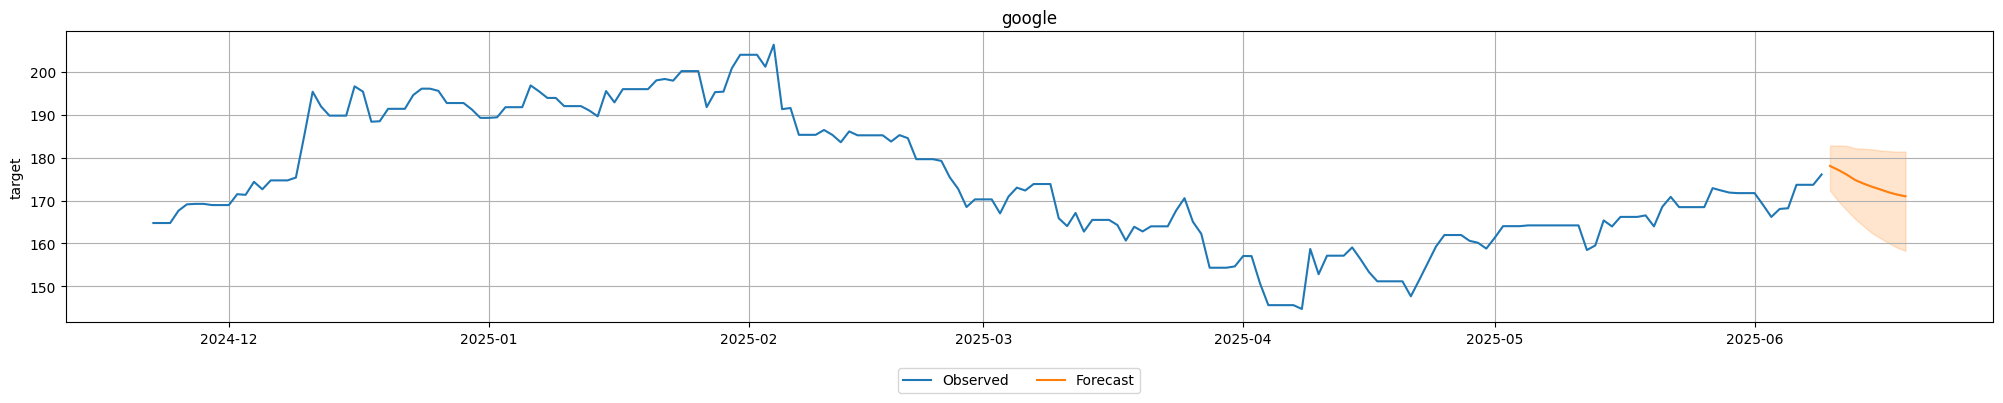

In [76]:
predictions = predictor.predict(test_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=data.item_ids[:2],
    max_history_length=200,
);